In [1]:
from typing import Tuple, Union, Optional
import jax
import jax.numpy as jnp
import jax.random as jr 
import equinox as eqx
import optax
from einops import rearrange
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import trange

cmap = "gray_r"

In [2]:
class Residual(eqx.Module):
    fn: eqx.Module
    
    def __init__(self, fn):
        self.fn = fn

    def __call__(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(eqx.Module):
    norm: eqx.nn.LayerNorm
    fn: eqx.Module

    def __init__(self, dim, fn):
        self.norm = eqx.nn.LayerNorm((dim,))
        self.fn = fn

    def __call__(self, x, **kwargs):
        return self.fn(jax.vmap(self.norm)(x), **kwargs)

In [3]:
class FeedForward(eqx.Module):
    net: Tuple[eqx.Module]

    def __init__(self, dim, hidden_dim, dropout=0., *, key):
        keys = jr.split(key)
        self.net = (
            eqx.nn.Linear(dim, hidden_dim, key=keys[0]),
            jax.nn.gelu,
            eqx.nn.Dropout(dropout),
            eqx.nn.Linear(hidden_dim, dim, key=keys[1]),
            eqx.nn.Dropout(dropout)
        )

    def __call__(self, x, key):
        for i, l in enumerate(self.net):
            if isinstance(l, eqx.nn.Dropout):
                x = l(x, key=jr.fold_in(key, i))
            else:
                x = jax.vmap(l)(x)
        return x


class Attention(eqx.Module):
    heads: int
    scale: float
    to_qkv: eqx.nn.Linear
    to_out: Union[eqx.nn.Sequential, eqx.nn.Identity]
    project_out: bool

    def __init__(self, dim, heads, dim_head, dropout=0., *, key):
        keys = jr.split(key)

        inner_dim = dim_head * heads
        self.project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = eqx.nn.Linear(dim, inner_dim * 3, use_bias=False, key=keys[0])

        self.to_out = (
            eqx.nn.Linear(inner_dim, dim, key=keys[1]),
            eqx.nn.Dropout(dropout)
        ) if self.project_out else eqx.nn.Identity()

    def __call__(self, x, key):
        n, _, h = *x.shape, self.heads

        _qkv = jax.vmap(self.to_qkv)(x)
        qkv = jnp.split(_qkv, 3, axis=-1)

        q, k, v = map(lambda t: rearrange(t, 'n (h d) -> h n d', h=h), qkv)

        # Dot-product multihead-attention 
        dots = jnp.einsum('h i d, h j d -> h i j', q, k) * self.scale
        attn = jax.nn.softmax(dots, axis=-1)
        out = jnp.einsum('h i j, h j d -> h i d', attn, v)

        out = rearrange(out, 'h n d -> n (h d)')

        if self.project_out:
            out = jax.vmap(self.to_out[0])(out)
            out = self.to_out[1](out, key=key)
        return out

In [4]:
class StochasticDepth_(eqx.Module):
    rate: float
    inference: bool 

    def __init__(self, rate, inference=False):
        """ Dropout whole layers of encoder. Do so by turning gradients off. """
        self.rate = rate
        self.inference = inference
    
    def __call__(self, layers, key):
        # This flag should be targeted by `eqx.nn.inference_mode(...)`
        if not self.inference:
            # Choose idx of layers to drop
            freeze_ix = jr.choice(
                key,
                jnp.arange(len(layers)), 
                (int(self.rate * len(layers)),)
            )
            # Treemap jax.lax.stop_gradient to array leaves of each layer module
            _layers = eqx.tree_at(
                # Return nodes of layers (that are linear layers themselves) 
                # that should be replaced in layers with 'frozen' equivalents
                lambda layers: [layers[i] for i in freeze_ix], 
                # Only stop gradients of arrays
                eqx.filter(layers, eqx.is_array),
                # Replace leaves with 'frozen' leaves
                replace_fn=lambda x: jax.lax.stop_gradient(x)
            )
            assert len(_layers) == len(layers)
        else:
            _layers = layers
        return _layers # Use affected layers


class StochasticDepth(eqx.Module):
    rate: float
    inference: bool

    def __init__(self, rate, inference=False):
        self.rate = rate 
        self.inference = inference

    def __call__(self, x, *, key=None, inference=None):
        if inference is None:
            inference = self.inference
        if isinstance(self.rate, (int, float)) and self.p == 0:
            inference = True
        if inference:
            return x
        elif key is None:
            raise RuntimeError(
                "Dropout requires a key when running in non-deterministic mode."
            )
        if not self.inference:
            keep_rate = 1. - self.rate
            random_tensor = keep_rate + jr.uniform(key, (1,) * x.ndim)
            random_tensor = jnp.floor(random_tensor)
            return (x / keep_rate) * random_tensor
        return x

In [15]:
class Transformer(eqx.Module):
    layers: Tuple[eqx.Module]
    stochastic_depths: Optional[Tuple[StochasticDepth]] = None

    def __init__(
        self, 
        dim, 
        depth, 
        heads, 
        dim_head, 
        mlp_dim, 
        dropout=0., 
        stochastic_depth_rate=0.5, 
        *, 
        key
    ):
        layers = []
        for _ in range(depth):
            key = jr.fold_in(key, _)
            keys = jr.split(key)
            layers.append(
                (
                    PreNorm(
                        dim, 
                        Attention(
                            dim, heads=heads, dim_head=dim_head, dropout=dropout, key=keys[0]
                        )
                    ),
                    PreNorm(
                        dim, 
                        FeedForward(
                            dim, mlp_dim, dropout=dropout, key=keys[1]
                        )
                    )
                )
            )
        self.layers = tuple(layers)

        if stochastic_depth_rate is not None:
            rates = jnp.linspace(0., stochastic_depth_rate, depth)
            stochastic_depths = [
                StochasticDepth(rate=rate) for rate in rates
            ]
        else:
            stochastic_depths = [None] * depth
        self.stochastic_depths = tuple(stochastic_depths)

    def __call__(self, x, key=None):
        if key is not None:
            keys = jr.split(key, (len(self.layers), 3))
        else:
            keys = [None] * len(self.layers)
        for _keys, (attn, ff), d in zip(
            keys, self.layers, self.stochastic_depths # Safely zipped?
        ): 
            if d is not None:
                attention = d(attn(x, key=_keys[0]), key=_keys[2])
            else:
                attention = attn(x, key=_keys[0])
            x = attention + x
            x = ff(x, key=_keys[1]) + x
        return x

In [6]:
class ConvEmbed(eqx.Module):
    conv_layers: Tuple[eqx.Module]

    def __init__(
        self, 
        in_channel, 
        out_channel, 
        kernel_size=7, 
        stride=2, 
        padding=3, 
        pool_kernel_size=3, 
        pool_stride=2,
        pool_padding=1,
        *,
        key
    ):
        conv_layers = [
            eqx.nn.Conv2d(
                in_channel, 
                out_channel, 
                kernel_size=kernel_size, 
                stride=stride,
                padding=padding, 
                use_bias=False,
                key=key
            ),
            jax.nn.relu,
            eqx.nn.MaxPool2d(
                kernel_size=pool_kernel_size, 
                stride=pool_stride, 
                padding=pool_padding
            )
        ]
        self.conv_layers = tuple(conv_layers)

    def sequence_length(self, n_channels, height, width):
        return self.__call__(jnp.zeros((n_channels, height, width))).shape[0]

    def __call__(self, x):
        for l in self.conv_layers:
            x = l(x)
        x = rearrange(x, 'd h w -> (h w) d')
        return x


class LinearEmbed(eqx.Module):
    linear: eqx.nn.Linear
    patch_size: int

    def __init__(self, in_size, out_size, patch_size, *, key):
        self.linear = eqx.nn.Linear(in_size, out_size, key=key)
        self.patch_size = patch_size
        
    def __call__(self, x):
        x = rearrange(
            x, 
            'c (h p1) (w p2) -> (h w) (p1 p2 c)', 
            p1=self.patch_size, 
            p2=self.patch_size
        )
        x = jax.vmap(self.linear)(x)
        return x


class CompactConvolutionalTransformer(eqx.Module):
    to_patch_embedding: Union[ConvEmbed, LinearEmbed]
    pos_embedding: jax.Array
    transformer: Transformer
    dropout: eqx.nn.Dropout
    pool: eqx.nn.Linear
    mlp_head: Tuple[eqx.nn.LayerNorm, eqx.nn.MLP]
    stochastic_depth: bool

    def __init__(
        self, 
        image_size, 
        patch_size, 
        num_classes, 
        dim, 
        depth, 
        heads, 
        in_channels=1,
        dim_head=64, 
        dropout=0.1, 
        emb_dropout=0.1, 
        scale_dim=4, 
        conv_embed=False,
        stochastic_depth=True,
        *,
        key
    ):

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = int(image_size / patch_size) ** 2
        patch_dim = in_channels * (patch_size ** 2)

        keys = jr.split(key, 6)

        # Linear or convolutional embeddings
        if conv_embed:
            self.to_patch_embedding = ConvEmbed(in_channels, dim, key=keys[0])
            num_patches = self.to_patch_embedding.sequence_length(
                in_channels, image_size, image_size
            )
        else:
            self.to_patch_embedding = LinearEmbed(patch_dim, dim, patch_size, key=keys[1])

        # Token position embedding
        self.pos_embedding = jr.normal(keys[2], (num_patches, dim))

        self.dropout = eqx.nn.Dropout(emb_dropout)

        # Transformer encoder layers
        self.transformer = Transformer(
            dim, depth, heads, dim_head, dim * scale_dim, dropout, key=keys[3]
        )

        # Sequence pooling (ViT uses class token)
        self.pool = eqx.nn.Linear(dim, 1, key=keys[4])

        self.mlp_head = (
            eqx.nn.LayerNorm((dim,)),
            eqx.nn.Linear(dim, num_classes, key=keys[5])
        )

        # Use layer regularisation in transformer or not
        self.stochastic_depth = stochastic_depth

    def __call__(self, x, key):
        x = self.to_patch_embedding(x)
        n, _ = x.shape

        x = x + self.pos_embedding[:n + 1]
        x = self.dropout(x, key=key)

        x = self.transformer(x, key=key)

        g = jax.vmap(self.pool)(x) # NOTE: this is a linear layer or a mean
        xl = jax.nn.softmax(g, axis=0)
        x = jnp.einsum('n l, n d -> l d', xl, x).squeeze(0)

        for l in self.mlp_head:
            x = l(x)
        return x

In [7]:
n_pix = 8

data = datasets.load_digits()

X = data.images.reshape(-1, 1, n_pix, n_pix)
Y = data.target[..., jnp.newaxis]

X.shape, Y.shape

((1797, 1, 8, 8), (1797, 1))

In [8]:
key = jr.key(0)

img = jnp.ones((1, n_pix, n_pix))

model = CompactConvolutionalTransformer(
    n_pix, 
    patch_size=1, 
    dim=128, 
    num_classes=10, 
    in_channels=1, 
    depth=4,
    heads=4,
    key=key
)

out = model(img, key)

sum(
    x.size for x in jax.tree_util.tree_leaves(model) 
    if eqx.is_array(x)
)

1063823

In [9]:
model = CompactConvolutionalTransformer(
    n_pix, 
    patch_size=1, 
    dim=8, 
    num_classes=10, 
    in_channels=1, 
    depth=4,
    heads=4,
    conv_embed=True,
    key=key
)

out = model(img, key)

sum(
    x.size for x in jax.tree_util.tree_leaves(model) 
    if eqx.is_array(x)
)

35679

In [ ]:
def loss(model, keys, x, y):
    y_ = jax.vmap(model)(x, key=keys)
    return optax.softmax_cross_entropy_with_integer_labels(y_, y.squeeze()).mean() 


@eqx.filter_jit
def make_step(key, model, opt_state, x, y):
    keys = jr.split(key, len(x))
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, keys, x, y)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def eval(model, key, x, y):
    model = eqx.nn.inference_mode(model, True)
    keys = jr.split(key, len(x))
    loss_value = loss(model, keys, x, y)
    return loss_value


def prepare(x, y):
    return x.numpy(), y.numpy()

In [10]:
n_epochs = 20_000
n_batch = 2000
opt = optax.adam(learning_rate=1e-4)

opt_state = opt.init(eqx.filter(model, eqx.is_array))

n_train = int(0.8 * len(X))
train_ds = TensorDataset(
    torch.as_tensor(X[:n_train]), torch.as_tensor(Y[:n_train])
)
valid_ds = TensorDataset(
    torch.as_tensor(X[n_train:]), torch.as_tensor(Y[n_train:])
)

key_train, key_valid = jr.split(key)

losses = []
with trange(n_epochs) as bar:
    set_dl_train = DataLoader(train_ds, batch_size=n_batch)
    set_dl_valid = DataLoader(valid_ds, batch_size=n_batch)

    for _ in bar:
        Lt = 0.
        for t, (x, y) in enumerate(set_dl_train):
            key = jr.fold_in(key_train, t)
            x, y = prepare(x, y)
            model, opt_state, _Lt = make_step(key, model, opt_state, x, y)
            Lt += _Lt

        Lv = 0.
        for v, (x, y) in enumerate(set_dl_valid):
            x, y = prepare(x, y)
            _Lv = eval(model, key_valid, x, y)
            Lv += _Lv
        
        Lt = Lt.item() / (t + 1) 
        Lv = Lv.item() / (v + 1)
        losses.append((Lt, Lv))
        bar.set_postfix_str(f"{Lt=:.3E} {Lv=:.3E}")

  0%|          | 0/20000 [00:00<?, ?it/s]

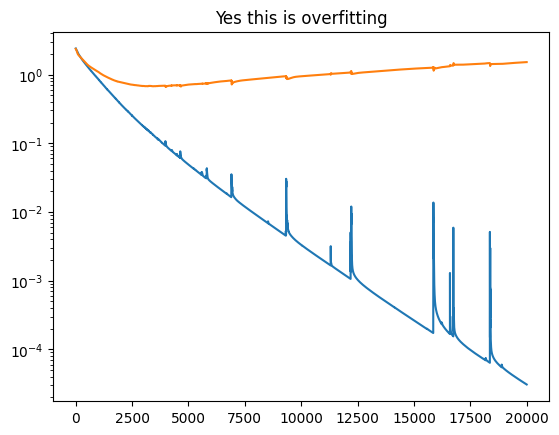

In [20]:
plt.figure()
plt.title("Yes this is overfitting")
plt.semilogy(losses)
plt.show()

In [21]:
from functools import partial

model = eqx.nn.inference_mode(model, True)
Y_ = jax.vmap(partial(model, key=jr.key(0)))(X)

accuracy = (Y.squeeze() == jnp.argmax(Y_, axis=1)).mean()
accuracy.item()

0.884251594543457